---

# Ансамбли моделей

В этой работе мы рассмотрим применение некоторых классических и хорошо себя показавших алгоритмов-ансамблей. Демонстрировать работу этих алгоритмов будем на данных о потреблении электричества.

# Описание набора данных

**Author**: M. Harries, J. Gama, A. Bifet  
**Source**: [Joao Gama](http://www.inescporto.pt/~jgama/ales/ales_5.html) - 2009  
**Please cite**: None  

**Electricity** is a widely used dataset described by M. Harries and analyzed by J. Gama (see papers below). This data was collected from the Australian New South Wales Electricity Market. In this market, prices are not fixed and are affected by demand and supply of the market. They are set every five minutes. Electricity transfers to/from the neighboring state of Victoria were done to alleviate fluctuations.

The dataset (originally named ELEC2) contains 45,312 instances dated from 7 May 1996 to 5 December 1998. Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label. The class label identifies the change of the price (UP or DOWN) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends).

The data was normalized by A. Bifet.

### Attribute information  
* Date: date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1
* Day: day of the week (1-7)
* Period: time of the measurement (1-48) in half hour intervals over 24 hours. Here normalized between 0 and 1
* NSWprice: New South Wales electricity price, normalized between 0 and 1
* NSWdemand: New South Wales electricity demand, normalized between 0 and 1
* VICprice: Victoria electricity price, normalized between 0 and 1
* VICdemand: Victoria electricity demand, normalized between 0 and 1
* transfer: scheduled electricity transfer between both states, normalized between 0 and 1

### Relevant papers  
M. Harries. Splice-2 comparative evaluation: Electricity pricing. Technical report, The University of South Wales, 1999.  
J. Gama, P. Medas, G. Castillo, and P. Rodrigues. Learning with drift detection. In SBIA Brazilian Symposium on Artificial Intelligence, pages 286–295, 2004.

# Разведочный анализ данных

Считайте набор данных в датафрейм

In [ ]:
# < ENTER YOUR CODE HERE >
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/DeepLearningCourse/electricity_train.csv")
data.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.425556,6,0.723404,0.076258,0.311366,0.003467,0.422915,0.414912,1
1,0.867351,7,0.808511,0.028131,0.299018,0.001838,0.325738,0.832018,0
2,0.031680,1,0.723404,0.055242,0.398691,0.003467,0.422915,0.414912,0
3,0.867793,3,1.000000,0.028822,0.396162,0.001014,0.394873,0.639474,0
4,0.880536,4,0.978723,0.040741,0.468908,0.002655,0.425427,0.630702,1


При помощи метода <code>.describe()</code> изучите набор данных «с высоты птичьего полета».

In [ ]:
# < ENTER YOUR CODE HERE >
data.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
count,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000,36249.000000
mean,0.498293,4.006566,0.500560,0.057828,0.425939,0.003455,0.423024,0.500243,0.424536
std,0.339907,1.993551,0.294998,0.039052,0.163390,0.010175,0.120600,0.153098,0.494279
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031945,2.000000,0.255319,0.035187,0.309729,0.002283,0.373382,0.414912,0.000000
50%,0.456263,4.000000,0.510638,0.048787,0.444213,0.003467,0.422915,0.414912,0.000000
75%,0.880492,6.000000,0.765957,0.074457,0.536745,0.003467,0.468669,0.605263,1.000000
max,1.000000,7.000000,1.000000,1.000000,0.980809,1.000000,1.000000,0.959211,1.000000


Убедитесь в отсутствии пропусков. Имеет смысл проверить сбалансированность классов. Введите долю элементов класса $1$.

In [ ]:
# < ENTER YOUR CODE HERE >
data.isna().sum()
data.loc[data['class'] == 1].shape[0] / data.shape[0]

0.4245358492648073

In [ ]:
data.isna().sum()

,0
date,0
day,0
period,0
nswprice,0
nswdemand,0
vicprice,0
vicdemand,0
transfer,0
class,0


Постройте матрицу корреляций. Определите пару наиболее коррелированных признаков.

In [ ]:
# < ENTER YOUR CODE HERE >
corr = data.corr()
np.fill_diagonal(corr.values, np.nan)
max_corr = corr.abs().max().max()
# Находим индексы признаков с максимальной корреляцией
most_corr_pair = np.where(corr.abs() == max_corr)
feature_1, feature_2 = most_corr_pair[0][0], most_corr_pair[1][0]
print(f"\nНаиболее коррелированные признаки: {feature_1} и {feature_2}")
# nswdemand, vicdemand


Наиболее коррелированные признаки: 4 и 6


In [ ]:
corr.style.background_gradient(cmap='coolwarm') # phai nho

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
date,nan,0.005840,0.001577,-0.153561,0.067692,0.002110,0.057239,0.405853,-0.003827
day,0.005840,nan,-0.000416,0.003168,-0.052946,0.001082,0.076904,-0.053012,-0.046841
period,0.001577,-0.000416,nan,0.105341,0.444579,0.022706,0.192153,-0.115437,0.154224
nswprice,-0.153561,0.003168,0.105341,nan,0.306982,0.288349,0.304492,-0.274764,0.386071
nswdemand,0.067692,-0.052946,0.444579,0.306982,nan,0.083510,0.667174,-0.264476,0.331741
vicprice,0.002110,0.001082,0.022706,0.288349,0.083510,nan,0.125489,-0.081112,0.065630
vicdemand,0.057239,0.076904,0.192153,0.304492,0.667174,0.125489,nan,-0.552870,0.231569
transfer,0.405853,-0.053012,-0.115437,-0.274764,-0.264476,-0.081112,-0.552870,nan,-0.119576
class,-0.003827,-0.046841,0.154224,0.386071,0.331741,0.065630,0.231569,-0.119576,nan


Постройте гистограммы распределений признаков.

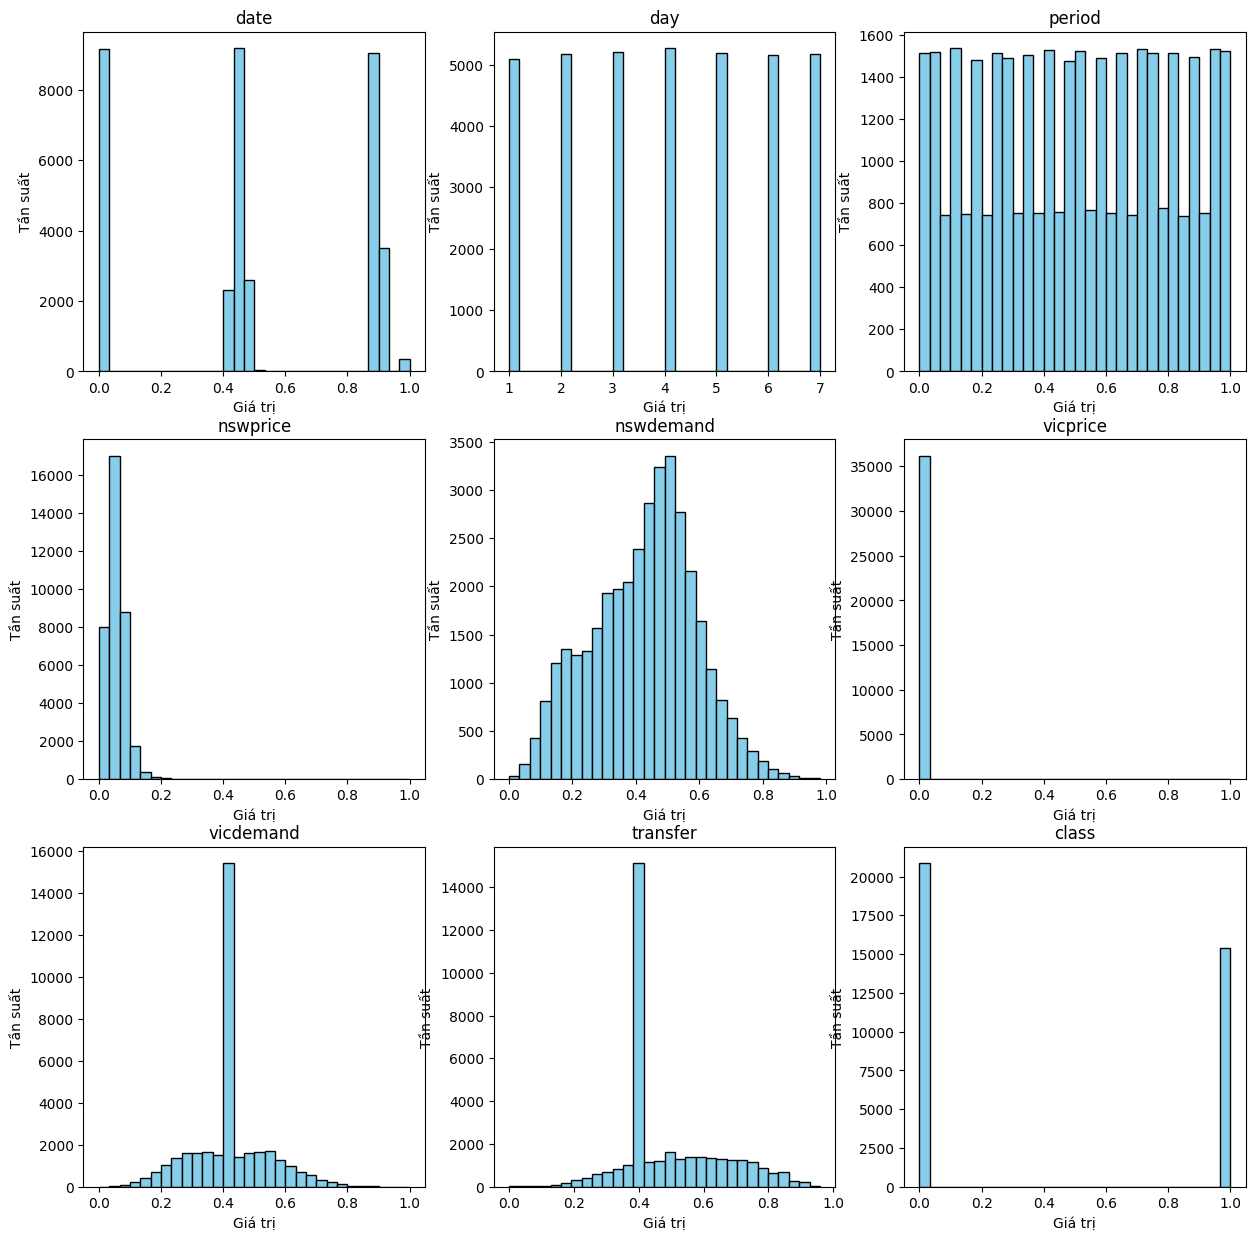

In [ ]:
# < ENTER YOUR CODE HERE >
num_cols = len(data.columns)
num_rows = (num_cols + 2) // 3  # Sắp xếp 3 cột mỗi hàng

# Tạo subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Biến thành danh sách 1 chiều để dễ truy cập

# Vẽ histogram cho từng cột
for i, col in enumerate(data.columns):
    axes[i].hist(data[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('Giá trị', fontsize=10)
    axes[i].set_ylabel('Tần suất', fontsize=10)

Из полученных иллюстраций видно, что в данных, скорее всего, как и ожидалось, есть некоторая периодичность. Более того, похоже, за нас уже поработали над заполнением пропусков или обработкой выбросов

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [ ]:
# < ENTER YOUR CODE HERE >
from sklearn.model_selection import train_test_split
X = data.loc[:, data.columns!='class']
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [ ]:
X

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer
0,0.425556,6,0.723404,0.076258,0.311366,0.003467,0.422915,0.414912
1,0.867351,7,0.808511,0.028131,0.299018,0.001838,0.325738,0.832018
2,0.031680,1,0.723404,0.055242,0.398691,0.003467,0.422915,0.414912
3,0.867793,3,1.000000,0.028822,0.396162,0.001014,0.394873,0.639474
4,0.880536,4,0.978723,0.040741,0.468908,0.002655,0.425427,0.630702
...,...,...,...,...,...,...,...,...
36244,0.447281,2,0.723404,0.087096,0.845879,0.006061,0.687209,0.327632
36245,0.429583,7,0.425532,0.058034,0.372657,0.003467,0.422915,0.414912
36246,0.013053,5,0.468085,0.041732,0.558465,0.003467,0.422915,0.414912
36247,0.889739,3,0.872340,0.078179,0.730586,0.005393,0.599171,0.476754


# Random Forests Classifier

Обучите модель <code>sklearn.ensemble.RandomForestClassifier</code> на тренировочных данных с параметрами, указанными в вашем индивидуальном задании.

In [ ]:
# < ENTER YOUR CODE HERE >
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=13)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=13)

Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [ ]:
# < ENTER YOUR CODE HERE >
y_hat = rfc.predict(X_train)
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_train, y_hat, digits=4))
print(f"Точность модели на тренировочных данных: {accuracy_score(y_train, y_hat)}")


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     16688
           1     1.0000    1.0000    1.0000     12311

    accuracy                         1.0000     28999
   macro avg     1.0000    1.0000    1.0000     28999
weighted avg     1.0000    1.0000    1.0000     28999

Точность модели на тренировочных данных: 1.0


Получили переобучение. Что же, еще раз можно ответить, что деревья принятия решений весьма склонны к переобучению.

## Добавление к лесу деревьев GridSearchCV

При помощи <code>sklearn.model_selection.GridSearchCV</code> обучите <code>RandomForestClassifier</code> на тренировочных данных c параметрами, указанными в вашем индивидуальном задании.

Подбираемые параметры:

<code>{'n_estimators': [100,300,500], 'max_leaf_nodes': list(range(6,10)), 'min_samples_leaf': [1,2,3]}</code>

In [ ]:
# < ENTER YOUR CODE HERE >
from sklearn.model_selection import GridSearchCV
params_grid = {'n_estimators': [100,300,500],
  'max_leaf_nodes': list(range(6,10)),
  'min_samples_leaf': [1,2,3]}

grid_search = GridSearchCV(RandomForestClassifier(
    bootstrap=False,
    class_weight='balanced',
    n_jobs=-1,
    max_features='sqrt',
    random_state=13),
    params_grid,
    verbose=4,
    cv=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.776 total time=   2.0s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.783 total time=   1.2s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=100;, score=0.774 total time=   1.2s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.774 total time=   3.5s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.780 total time=   3.5s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=300;, score=0.775 total time=   5.8s
[CV 1/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.774 total time=   5.8s
[CV 2/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.779 total time=   7.0s
[CV 3/3] END max_leaf_nodes=6, min_samples_leaf=1, n_estimators=500;, score=0.774 total time=   6.8s
[CV 1/3] END max_leaf_nodes=6

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(bootstrap=False,
                                              class_weight='balanced',
                                              n_jobs=-1, random_state=13),
             param_grid={'max_leaf_nodes': [6, 7, 8, 9],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 300, 500]},
             verbose=4)

Выберите лучшую модель. Рекомендуем использовать поле <code>best_estimator_</code> объекта класса <code>grid_search</code>. В поле <code>best_params_</code> этого же объекта можно найти параметры лучшей модели.

In [ ]:
# < ENTER YOUR CODE HERE >
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_leaf_nodes=9, n_jobs=-1, random_state=13)

In [ ]:
print(grid_search.best_params_['min_samples_leaf'])

1


In [ ]:
print(grid_search.best_params_['n_estimators'])

100


Постройте <code>classification_report</code> полученной модели на **тренировочных данных**. Введите значение точности модели на **тренировочных данных**.

In [ ]:
# < ENTER YOUR CODE HERE >
y_hat = grid_search.best_estimator_.predict(X_train)
print(classification_report(y_train, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.7938    0.8724    0.8313     16688
           1     0.8002    0.6928    0.7427     12311

    accuracy                         0.7962     28999
   macro avg     0.7970    0.7826    0.7870     28999
weighted avg     0.7965    0.7962    0.7936     28999



Постройте <code>classification_report</code> полученной модели на **тестовых данных**. Введите значение точности модели на **тестовых данных**.

In [ ]:
# < ENTER YOUR CODE HERE >
y_hat = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.7849    0.8617    0.8215      4172
           1     0.7839    0.6800    0.7283      3078

    accuracy                         0.7846      7250
   macro avg     0.7844    0.7708    0.7749      7250
weighted avg     0.7845    0.7846    0.7819      7250



От переобучения избавились, но точность кажется низкой.

Один из плюсов случайного леса — можно посмотреть на важность признаков при классификации (обратная задача). Значения важности можно найти в поле <code>feature_importances_</code> модели. Определите название самого важного признака модели.

In [ ]:
# < ENTER YOUR CODE HERE >
feature_names = [i for i in (data.columns)]
print(grid_search.best_estimator_.feature_importances_)
np.argmax(grid_search.best_estimator_.feature_importances_)
print(f"Самый важный признак: {feature_names[np.argmax(grid_search.best_estimator_.feature_importances_)]}")

[0.04687095 0.01396212 0.11425469 0.43406869 0.19128554 0.1595406
 0.03162369 0.00839372]
Самый важный признак: nswprice


Попробуем улучшить результаты, используя другие виды ансамблей.

# Voting Classifier

Обучает все модели, поданные на вход, и предсказывает финальный результат либо по большему числу одинаковых ответов, которые дали модели (hard), либо вычисляет вероятность отнесения объектов к классам по всем моделям и берет argmax.

Используйте объект <code>sklearn.ensemble.VotingClassifier</code> с параметром <code>voting='hard'</code>. В качестве базовых алгоритмов используйте классификаторы с соответствующими параметрами, указанными в вашем индивидуальном задании. Обучите модель на тренировочных данных

In [ ]:
# < ENTER YOUR CODE HERE >
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

lr = LogisticRegression(solver='liblinear', random_state=13)
svc = SVC(random_state=13)
sgd = SGDClassifier(random_state=13)

model = VotingClassifier(estimators=[('linear', lr), ('svc', svc), ('sgd', sgd)], voting='hard')
model.fit(X_train, y_train)

VotingClassifier(estimators=[('linear',
                              LogisticRegression(random_state=13,
                                                 solver='liblinear')),
                             ('svc', SVC(random_state=13)),
                             ('sgd', SGDClassifier(random_state=13))])

Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >
y_hat = model.predict(X_train)
print(classification_report(y_train, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.7388    0.8874    0.8063     16688
           1     0.7901    0.5746    0.6653     12311

    accuracy                         0.7546     28999
   macro avg     0.7644    0.7310    0.7358     28999
weighted avg     0.7606    0.7546    0.7465     28999



Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >
y_hat = model.predict(X_test)
print(classification_report(y_test, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.7338    0.8893    0.8041      4172
           1     0.7894    0.5627    0.6571      3078

    accuracy                         0.7506      7250
   macro avg     0.7616    0.7260    0.7306      7250
weighted avg     0.7574    0.7506    0.7417      7250



# Bagging Classifier

Создает несколько объектов одного класса (несколько моделей) и обучает их на непересекающихся подмножествах тренировочных данных, а дальше усредняет ответы.

На основе <code>sklearn.ensemble.BaggingClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging_model = BaggingClassifier(
    DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5,
    max_features=0.5,
    bootstrap=False,
  random_state=13)

bagging_model.fit(X_train, y_train)

y_pred = bagging_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))
print(f"Точность модели на тестовых данных: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0     0.8657    0.9314    0.8974      4172
           1     0.8964    0.8041    0.8477      3078

    accuracy                         0.8774      7250
   macro avg     0.8810    0.8678    0.8726      7250
weighted avg     0.8787    0.8774    0.8763      7250

Точность модели на тестовых данных: 0.8773793103448276


In [ ]:
# < ENTER YOUR CODE HERE >
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bagging = BaggingClassifier(
    DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5,
    max_features=0.5,
    bootstrap=False,
  random_state=13)
bagging.fit(X_train, y_train)

BaggingClassifier(bootstrap=False,
                  estimator=DecisionTreeClassifier(class_weight='balanced'),
                  max_features=0.5, max_samples=0.5, random_state=13)

Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >
y_hat = bagging.predict(X_train)
print(classification_report(y_train, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.9814    0.9934    0.9874     16688
           1     0.9909    0.9745    0.9826     12311

    accuracy                         0.9854     28999
   macro avg     0.9862    0.9840    0.9850     28999
weighted avg     0.9854    0.9854    0.9854     28999



Вычислите точность модели на **тестовых данных**

In [ ]:
y_hat = bagging.predict(X_test)
print(classification_report(y_test, y_hat, digits=3))

              precision    recall  f1-score   support

           0      0.866     0.931     0.897      4172
           1      0.896     0.804     0.848      3078

    accuracy                          0.877      7250
   macro avg      0.881     0.868     0.873      7250
weighted avg      0.879     0.877     0.876      7250



# Gradient Boosting Classifier

Градиентный бустинг работает примерно так: создается несколько объектов класса (несколько моделей), они выстраиваются в цепочку так, чтобы каждый следующий пытался исправить ошибки предыдущего. Склонен к переобучению.

Обучите модель на основе <code>sklearn.ensemble.GradientBoostingClassifier</code> с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [ ]:
# < ENTER YOUR CODE HERE >
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=500, learning_rate=0.8, random_state=13, max_depth=2)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.8, max_depth=2, n_estimators=500,
                           random_state=13)

Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >
y_hat = gbc.predict(X_train)
print(classification_report(y_train, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.9373    0.9448    0.9411     16688
           1     0.9244    0.9144    0.9194     12311

    accuracy                         0.9319     28999
   macro avg     0.9309    0.9296    0.9302     28999
weighted avg     0.9318    0.9319    0.9318     28999



Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >
y_hat = gbc.predict(X_test)
print(classification_report(y_test, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.9056    0.9130    0.9093      4172
           1     0.8807    0.8710    0.8759      3078

    accuracy                         0.8952      7250
   macro avg     0.8932    0.8920    0.8926      7250
weighted avg     0.8951    0.8952    0.8951      7250



# AdaBoost Classifier

Работает похожим на градиентный бустинг образом, только последующие модели не пытаются исправить ошибку предыдущих: сначала первый объект обучается на всем датасете, а следующий на основе опыта предыдущего обновляет свои веса так, чтобы исправлять ошибочные предсказания.

На основе <code>sklearn.ensemble.AdaBoostClassifier</code>, используя <code>DecisionTreeClassifier</code> обучите модель с параметрами, указанными в вашем индивидуальном задании на тренировочных данных.

In [59]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score

ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=300,
    learning_rate=0.5,
    random_state=13
)

ada_model.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    max_depth=3),
                   learning_rate=0.5, n_estimators=300, random_state=13)

In [64]:
y_ada_pred = ada_model.predict(X_test)

print(round(accuracy_score(y_test, y_ada_pred), 3))

0.8


In [ ]:
print(classification_report(y_test, y_ada_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      4172
           1       0.78      0.74      0.76      3078

    accuracy                           0.80      7250
   macro avg       0.80      0.79      0.79      7250
weighted avg       0.80      0.80      0.80      7250



Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >
y_hat = ada_model.predict(X_train)
print(classification_report(y_train, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.8250    0.8477    0.8362     16688
           1     0.7855    0.7563    0.7707     12311

    accuracy                         0.8089     28999
   macro avg     0.8053    0.8020    0.8034     28999
weighted avg     0.8083    0.8089    0.8084     28999



Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >
y_hat = ada_model.predict(X_test)
print(classification_report(y_test, y_hat, digits=3))

              precision    recall  f1-score   support

           0      0.816     0.842     0.829      4172
           1      0.776     0.743     0.759      3078

    accuracy                          0.800      7250
   macro avg      0.796     0.792     0.794      7250
weighted avg      0.799     0.800     0.799      7250



# Stacking Classifier

Обучает несколько объектов класса (несколько моделей) на всем наборе данных, а после — обучает отдельный классификатор на метданных — ответах, полученных обученными ранее моделями.

Используйте объект <code>sklearn.ensemble.StackingClassifier</code>. Базовые алгоритмы и решающий, а также соответствующие параметры указанны в вашем индивидуальном задании. Обучите модель на тренировочных данных.

In [ ]:
# < ENTER YOUR CODE HERE >
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier


rd = RandomForestClassifier(random_state=13)
svc = SVC(random_state=13)

model = StackingClassifier(estimators=[('svc', svc), ('rd', rd)], final_estimator=LogisticRegression(random_state=13))
model.fit(X_train, y_train)


Вычислите точность модели на **тренировочных данных**

In [ ]:
# < ENTER YOUR CODE HERE >
y_hat = model.predict(X_train)
print(classification_report(y_train, y_hat, digits=4))

Вычислите точность модели на **тестовых данных**

In [ ]:
# < ENTER YOUR CODE HERE >
y_hat = model.predict(X_test)
print(classification_report(y_test, y_hat, digits=4))

# Задание 2


In [ ]:
data_train = pd.read_csv("/content/drive/MyDrive/DeepLearningCourse/electricity_train.csv")
data_test = pd.read_csv("/content/drive/MyDrive/DeepLearningCourse/electricity_reserved.csv")
X = data.drop('class', axis=1)
y = data['class']

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

rd = RandomForestClassifier(random_state=13)
svc = SVC(kernel='rbf',random_state=13)
gbd = GradientBoostingClassifier(n_estimators=500, learning_rate=0.5, random_state=13, max_depth=5)
abc = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=300,
    learning_rate=0.5,
    random_state=13)

model = StackingClassifier(estimators=[('rd', rd), ('gbd', gbd), ('abc', abc)], final_estimator= SVC(kernel='rbf',random_state=13))
model.fit(X, y)

In [ ]:
result = model.predict(data_test)


In [ ]:
print(list(result))